<center><img src='./Figs/cs-logo.png' width=200></center>



<h6><center></center></h6>

<h1>
<hr style=" border:none; height:3px;">
<center> Mention IA - Reinforcement Learning - Task 3</center>
<hr style=" border:none; height:3px;">
</h1>

### Parking Stable Baselines

In [ ]:
! pip install "stable-baselines3[extra]>=2.0.0a4"

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 9.8 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import gymnasium as gym
import highway_env
import numpy as np
import pickle
import matplotlib.pyplot as plt
from IPython.display import clear_output
from copy import deepcopy
from stable_baselines3 import HerReplayBuffer, SAC

### Parking with HER and SAC 
We begin by loading a custom parking environment configuration.
This setup includes:

    ContinuousAction for steering and acceleration.

    KinematicsGoal observations to include spatial and velocity features.

    Customized rewards (goal_reward, collision_penalty, etc.) and visual rendering options.

Model: SAC with Hindsight Experience Replay (HER)

We use the Soft Actor-Critic (SAC) algorithm enhanced with HER to deal with sparse rewards. HER allows the agent to reinterpret failed experiences as successful by changing the goal retrospectively especially useful for tasks like parking. We reload the model and evaluate it over multiple episodes to assess stability and performance.

In [2]:
# Load your custom parking config
with open("config_parking.pkl", "rb") as f:
    parking_config = pickle.load(f)

# Create the environment and apply config
# env = gym.make("parking-v0")
env = gym.make("parking-v0", render_mode="rgb_array")
env.unwrapped.configure(parking_config)

# Define and train the SAC model with HER
model = SAC(
    "MultiInputPolicy",
    env,
    replay_buffer_class=HerReplayBuffer,
    replay_buffer_kwargs=dict(
        n_sampled_goal=4,
        goal_selection_strategy="future",
    ),
    verbose=1,
    buffer_size=int(1e6),
    learning_rate=1e-3,
    gamma=0.95,
    batch_size=256,
    learning_starts=1000,
    policy_kwargs=dict(net_arch=[256, 256, 256]),
)

# Train the model
model.learn(total_timesteps=int(1e5))
model.save("her_sac_parking")

# Reload the trained model
model = SAC.load("her_sac_parking", env=env)

# Evaluate the agent
obs, _ = env.reset()
episode_reward = 0
for _ in range(100):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    done = truncated or terminated
    episode_reward += reward
    if done or info.get("is_success", False):
        print("Reward:", episode_reward, "Success?", info.get("is_success", False))
        episode_reward = 0.0
        obs, _ = env.reset()

# Visualization of one full episode
def run_one_episode(env, agent, display=True, max_steps=300):
    display_env = deepcopy(env)
    obs, _ = display_env.reset()
    done = False
    rewards = 0
    step = 0

    while not done and step < max_steps:
        action, _ = agent.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = display_env.step(action)
        done = terminated or truncated
        rewards += reward
        step += 1

        if display:
            clear_output(wait=True)
            plt.imshow(display_env.render())
            plt.axis("off")
            plt.show()

    if display:
        display_env.close()
    print(f"Episode total reward: {rewards}")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 68       |
|    ep_rew_mean     | -39.8    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 4        |
|    fps             | 57       |
|    time_elapsed    | 4        |
|    total_timesteps | 272      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 59.5     |
|    ep_rew_mean     | -35.7    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 8        |
|    fps             | 56       |
|    time_elapsed    | 8        |
|    total_timesteps | 476      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 62.2     |
|    ep_rew_mean     | -36.8    |
|    success_rate    

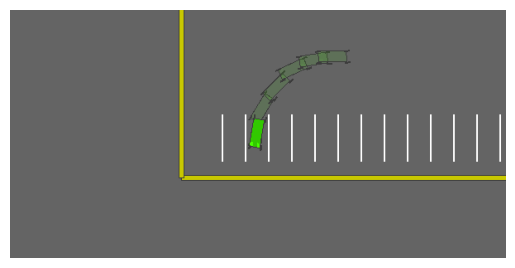

Episode total reward: -7.329310502575699


In [3]:
# Render using your config
env = gym.make("parking-v0", render_mode="rgb_array")
env.unwrapped.configure(parking_config)
run_one_episode(env, model, display=True)

Evaluation Metrics:

    Total reward per episode

    Binary success flag (is_success)

    Plotting reward evolution over 10 episodes

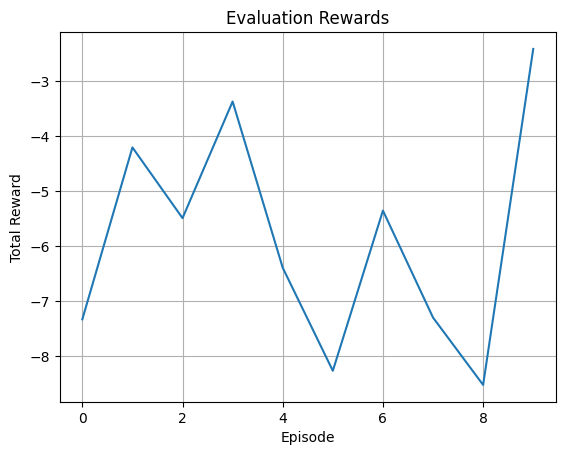

In [4]:
rewards = []
for _ in range(10):
    obs, _ = env.reset()
    done = False
    total = 0
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total += reward
    rewards.append(total)

plt.plot(rewards)
plt.title("Evaluation Rewards")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()

In [5]:
successes = 0
for _ in range(10):
    obs, _ = env.reset()
    done = False
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
    if info.get("is_success", False):
        successes += 1

print(f"Success rate: {successes}/10")

Success rate: 10/10


In [6]:
print(f"Mean reward over 10 episodes: {np.mean(rewards):.2f} ± {np.std(rewards):.2f}")

Mean reward over 10 episodes: -5.87 ± 1.96


We simulate one final full episode and save it as a video.

In [10]:
import imageio

frames = []
obs, _ = env.reset()
done = False
while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    frame = env.render()
    if frame is not None:
        frames.append(frame)
    done = terminated or truncated

imageio.mimsave("parking_task3.mp4", frames, fps=15)

from IPython.display import Video
Video("parking_task3.mp4", embed=True, width=600)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 300) to (608, 304) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


The SAC + HER agent successfully learns how to park by leveraging hindsight relabeling. The rendered video and reward evolution plot visually confirm the improvement in policy performance.